In [1]:
import os
import sys
import random
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import sumolib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import sys
import io
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import pandas as pd


if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import traci
from sumolib import checkBinary
sumoBinary = checkBinary('sumo-gui')
# sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

SUMO_HOME found
Using device: cuda


## Check if there are parallel edges (multigrpah)

In [2]:
net = sumolib.net.readNet('./config/osm.net.xml.gz')

# Extract nodes and edges
nodes = net.getNodes()
edges = net.getEdges()

edges_from_to = {}
for edge in edges:
    from_node = edge.getFromNode().getID()
    to_node = edge.getToNode().getID()
    if (from_node, to_node) not in edges_from_to:
        edges_from_to[(from_node, to_node)] = [edge]
    else:
        edges_from_to[(from_node, to_node)].append(edge)

for from_node, to_node in edges_from_to.keys():
    if len(edges_from_to[(from_node, to_node)]) > 1:
        print(from_node, to_node)
        for edge in edges_from_to[(from_node, to_node)]:
            print(edge.getID())
            num_lanes = edge.getLaneNumber()
            speed_limit = edge.getSpeed()
            length = edge.getLength()

In [3]:
def randomTrips(dur=10000, density=12):
    os.system("python $SUMO_HOME/tools/randomTrips.py -n config/osm.net.xml.gz -r config/osm.passenger.trips.xml -e " + str(dur) + " -l --insertion-density=" + str(density))

def shouldContinueSim():
    numVehicles = traci.simulation.getMinExpectedNumber()
    return True if numVehicles > 0 else False

def restart(dur, density):
    with io.StringIO() as buf, redirect_stdout(buf):
        try:
            traci.close()
        except:
            pass
        randomTrips(dur, density)
        traci.start(sumoCmd)
        step = 0
        for i in range(100):
            traci.simulationStep()
            step += 1

In [4]:
def get_trajectories(dur=10000, density=12):
    randomTrips(dur, density)
    trajectories = {}
    traci.start(sumoCmd)
    while shouldContinueSim():
        traci.simulationStep()
        for vehicle in traci.vehicle.getIDList():
            if vehicle not in trajectories:
                trajectories[vehicle] = []
            x, y = traci.vehicle.getPosition(vehicle)
            speed = traci.vehicle.getSpeed(vehicle)
            direction = np.deg2rad(traci.vehicle.getAngle(vehicle))
            velocity_x = speed * np.sin(direction)
            velocity_y = speed * np.cos(direction)
            trajectories[vehicle] += [x, y, velocity_x, velocity_y]
    traci.close()
    return trajectories
trajectories = get_trajectories(density=6)

Success.
 Retrying in 1 seconds


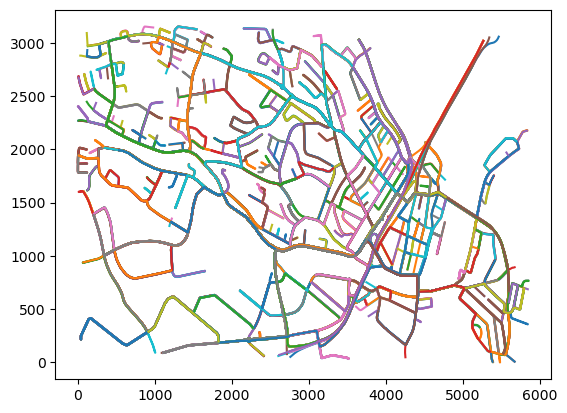

In [5]:
# plot the first 10 trajectories
def plot_trajectories(trajectories, n=10):
    for i, vehicle in enumerate(trajectories.keys()):
        if i > n:
            break
        trajectory = trajectories[vehicle]
        x = trajectory[::4]
        y = trajectory[1::4]
        plt.plot(x, y)
    plt.show()
plot_trajectories(trajectories, 1000)

In [6]:
# pad trajectories to have the same length
def pad_trajectories(trajectories):
    max_len = 0
    for vehicle in trajectories.keys():
        max_len = max(max_len, len(trajectories[vehicle]))
    for vehicle in trajectories.keys():
        trajectories[vehicle] += [0] * (max_len - len(trajectories[vehicle]))
    return trajectories

trajectories = pad_trajectories(trajectories)
df = pd.DataFrame(list(trajectories.values()), index=trajectories.keys())
print(df.head())
df.to_csv('rovaniemi_trajectories.csv')

          0            1     2     3            4            5         6     \
0   953.581280  2990.244799   0.0  -0.0   953.745028  2988.586939  0.163751   
1  5415.584697   955.606590  -0.0  -0.0  5414.587023   954.196302 -0.997697   
2  3221.728248  2599.451746   0.0  -0.0  3224.008365  2599.015736  2.280141   
3  5297.544172   745.135206   0.0   0.0  5300.001452   745.634375  2.456259   
4  1820.550227   180.527092  -0.0  -0.0  1818.803085   180.416249 -1.747140   

       7            8            9     ...  3038  3039  3040  3041  3042  \
0 -1.657893   954.094489  2985.048822  ...   0.0   0.0   0.0   0.0   0.0   
1 -1.410321  5412.720564   951.557919  ...   0.0   0.0   0.0   0.0   0.0   
2 -0.436014  3228.133680  2597.072703  ...   0.0   0.0   0.0   0.0   0.0   
3  0.504034  5304.591339   746.435702  ...   0.0   0.0   0.0   0.0   0.0   
4 -0.110843  1815.153577   180.184715  ...   0.0   0.0   0.0   0.0   0.0   

   3043  3044  3045  3046  3047  
0   0.0   0.0   0.0   0.0   0.0  
